In [ ]:
# Mount Google Drive in Colab

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Import Libraries

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [ ]:
# Get Dataset from Google Drive

# !unzip "/content/drive/MyDrive/Drowsiness Dataset/Non Generative Dataset.zip" -d "Non Generative Dataset"

In [ ]:
# Loading Dataset

import pathlib
data_dir = pathlib.Path("/content/Non Generative Dataset/Without Generative")

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2615


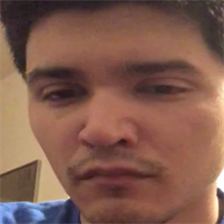

In [ ]:
drowsy = list(data_dir.glob('Drowsy/*'))
PIL.Image.open(str(drowsy[1]))

In [ ]:
# Set input parameters

batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# Split Dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  label_mode="binary",
  seed=321,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2615 files belonging to 2 classes.
Using 1831 files for training.


In [ ]:
# Split Dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  label_mode="binary",
  seed=321,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2615 files belonging to 2 classes.
Using 784 files for validation.


In [ ]:
# Split Dataset into validation and test

val_batches = tf.data.experimental.cardinality(val_ds)
val_ds = val_ds.shuffle(buffer_size=1000)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 13
Number of test batches: 12


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Drowsy', 'Non Drowsy']


In [ ]:
# Get shape of input

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 1)


In [ ]:
## Loading VGG16 model

from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights = "imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable=False  ## Not trainable weights

In [ ]:
# Setup model structure

from tensorflow.keras import layers, models, regularizers
model=models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    # layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Set learning rate, optimizer and metrics

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')]
              )

In [ ]:
# Define Early Stopping - Unused in final training

from tensorflow.keras import callbacks
es_val_loss = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)
es_val_accuracy = callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
# Train Model

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=16
  # callbacks=[es_val_loss, es_val_accuracy]
)

Epoch 1/16
58/58 [==============================] - 14s 198ms/step - loss: 0.7614 - accuracy: 0.5128 - precision: 0.5214 - recall: 0.2536 - val_loss: 0.7080 - val_accuracy: 0.5350 - val_precision: 0.5337 - val_recall: 0.8365
Epoch 2/16
58/58 [==============================] - 13s 211ms/step - loss: 0.7149 - accuracy: 0.5369 - precision: 0.5402 - recall: 0.4643 - val_loss: 0.6859 - val_accuracy: 0.7050 - val_precision: 0.7072 - val_recall: 0.6632
Epoch 3/16
58/58 [==============================] - 12s 195ms/step - loss: 0.6952 - accuracy: 0.5844 - precision: 0.5904 - recall: 0.5379 - val_loss: 0.6676 - val_accuracy: 0.6750 - val_precision: 0.7021 - val_recall: 0.6408
Epoch 4/16
58/58 [==============================] - 12s 201ms/step - loss: 0.6679 - accuracy: 0.6374 - precision: 0.6519 - recall: 0.5818 - val_loss: 0.6405 - val_accuracy: 0.7225 - val_precision: 0.7548 - val_recall: 0.6158
Epoch 5/16
58/58 [==============================] - 12s 191ms/step - loss: 0.6419 - accuracy: 0.6789

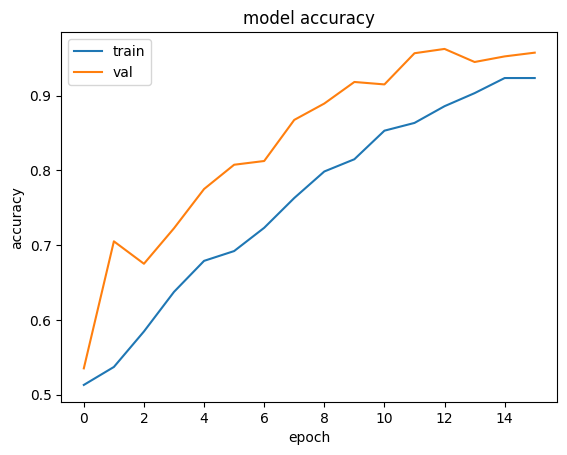

In [ ]:
# Graph Plots

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

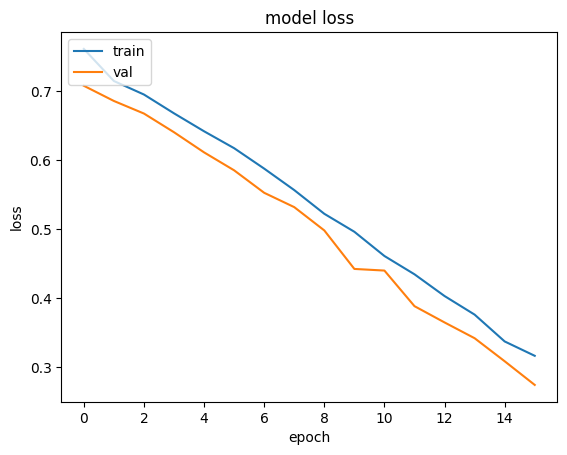

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Save model to Google Drive

model.save('/content/drive/MyDrive/Drowsiness Dataset/normal_dataset_model.keras')

In [ ]:
# Predict on test set

results = model.evaluate(x=test_ds)

12/12 [==============================] - 3s 134ms/step - loss: 0.2655 - accuracy: 0.9635 - precision: 0.9381 - recall: 0.9891
